In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data-Chillers.csv")

df.head().T

,0,1,2,3,4
time,29-08-2017 11:00,29-08-2017 12:00,29-08-2017 13:00,29-08-2017 14:00,29-08-2017 15:00
IOT_Sensor_Reading,-0.015871,-0.101576,-0.118241,-0.214262,-0.249972
Error_Present,0.353986,0.353986,0.353986,0.353986,0.353986
Sensor_2,-0.787655,-0.787655,-0.787655,-0.787655,-0.787655
Sensor_Value,0.008144,-0.02986,-0.021717,0.008144,-0.108583


In [3]:
renamed_columns = [col.replace(" ", "_").lower() for col in df.columns]

df.columns = renamed_columns

df.head().T

,0,1,2,3,4
time,29-08-2017 11:00,29-08-2017 12:00,29-08-2017 13:00,29-08-2017 14:00,29-08-2017 15:00
iot_sensor_reading,-0.015871,-0.101576,-0.118241,-0.214262,-0.249972
error_present,0.353986,0.353986,0.353986,0.353986,0.353986
sensor_2,-0.787655,-0.787655,-0.787655,-0.787655,-0.787655
sensor_value,0.008144,-0.02986,-0.021717,0.008144,-0.108583


In [4]:
df.shape

(1895, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                1895 non-null   object 
 1   iot_sensor_reading  1895 non-null   float64
 2   error_present       1895 non-null   float64
 3   sensor_2            1895 non-null   float64
 4   sensor_value        1895 non-null   float64
dtypes: float64(4), object(1)
memory usage: 74.2+ KB


In [6]:
df.describe()

,iot_sensor_reading,error_present,sensor_2,sensor_value
count,1895.000000,1895.000000,1895.000000,1895.000000
mean,-0.005885,0.003773,-0.011604,-0.026563
std,0.415492,0.820630,1.324344,0.405068
min,-1.603790,-3.115077,-3.281895,-1.468581
25%,-0.222198,-0.424783,-0.853293,-0.230738
50%,-0.022220,0.000000,0.065638,-0.065150
75%,0.190455,0.424783,0.787655,0.207664
max,1.406987,3.256671,4.397739,1.460437


### the response varible

<Axes: >

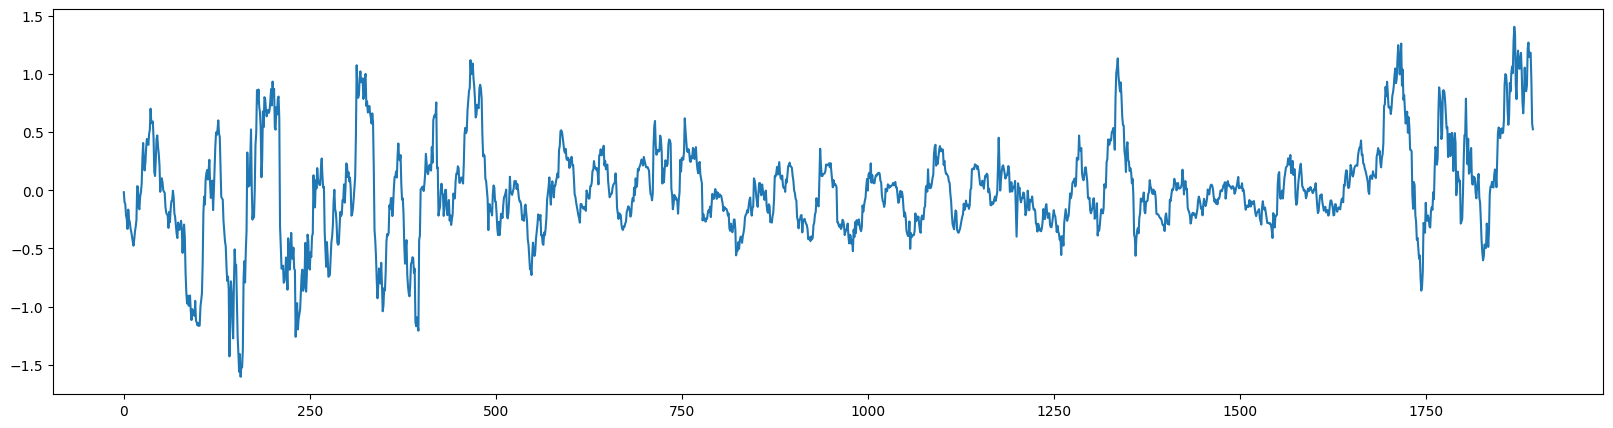

In [7]:
df["iot_sensor_reading"].plot(figsize=(20, 5))

In [8]:
df["time"] = pd.to_datetime(df["time"])

In [9]:
df.head()

,time,iot_sensor_reading,error_present,sensor_2,sensor_value
0,2017-08-29 11:00:00,-0.015871,0.353986,-0.787655,0.008144
1,2017-08-29 12:00:00,-0.101576,0.353986,-0.787655,-0.029860
2,2017-08-29 13:00:00,-0.118241,0.353986,-0.787655,-0.021717
3,2017-08-29 14:00:00,-0.214262,0.353986,-0.787655,0.008144
4,2017-08-29 15:00:00,-0.249972,0.353986,-0.787655,-0.108583


In [10]:
# create time of day column

hour = df["time"].dt.hour

df["time_of_day"] = pd.cut(hour, bins =[0, 11, 16, 23], labels=["morning", "noon", "evening"])

df.head()

,time,iot_sensor_reading,error_present,sensor_2,sensor_value,time_of_day
0,2017-08-29 11:00:00,-0.015871,0.353986,-0.787655,0.008144,morning
1,2017-08-29 12:00:00,-0.101576,0.353986,-0.787655,-0.029860,noon
2,2017-08-29 13:00:00,-0.118241,0.353986,-0.787655,-0.021717,noon
3,2017-08-29 14:00:00,-0.214262,0.353986,-0.787655,0.008144,noon
4,2017-08-29 15:00:00,-0.249972,0.353986,-0.787655,-0.108583,noon


### get the max and min iot_sensor_reading for each time of day

In [11]:
max_iot_sensor_reading = df.groupby("time_of_day")["iot_sensor_reading"].max()
max_iot_sensor_reading

time_of_day
morning    1.249068
noon       1.262558
evening    1.406987
Name: iot_sensor_reading, dtype: float64

In [12]:
max_iot_sensor_reading = df.groupby("time_of_day")["iot_sensor_reading"].min()
max_iot_sensor_reading

time_of_day
morning   -1.603790
noon      -1.428413
evening   -1.273668
Name: iot_sensor_reading, dtype: float64

### get the max and min iot_sensor_reading for each day of the week

In [13]:
df["day_of_week"] = df["time"].dt.day_name()

df.head()

,time,iot_sensor_reading,error_present,sensor_2,sensor_value,time_of_day,day_of_week
0,2017-08-29 11:00:00,-0.015871,0.353986,-0.787655,0.008144,morning,Tuesday
1,2017-08-29 12:00:00,-0.101576,0.353986,-0.787655,-0.029860,noon,Tuesday
2,2017-08-29 13:00:00,-0.118241,0.353986,-0.787655,-0.021717,noon,Tuesday
3,2017-08-29 14:00:00,-0.214262,0.353986,-0.787655,0.008144,noon,Tuesday
4,2017-08-29 15:00:00,-0.249972,0.353986,-0.787655,-0.108583,noon,Tuesday


In [14]:
max_iot_sensor_reading = df.groupby("day_of_week")["iot_sensor_reading"].max()
max_iot_sensor_reading

day_of_week
Friday       0.628502
Monday       1.119717
Saturday     0.885616
Sunday       0.861809
Thursday     1.341914
Tuesday      1.134795
Wednesday    1.406987
Name: iot_sensor_reading, dtype: float64

In [15]:
max_iot_sensor_reading = df.groupby("day_of_week")["iot_sensor_reading"].min()
max_iot_sensor_reading

day_of_week
Friday      -1.260178
Monday      -1.428413
Saturday    -1.166537
Sunday      -0.743568
Thursday    -0.911803
Tuesday     -1.603790
Wednesday   -1.040361
Name: iot_sensor_reading, dtype: float64

In [16]:
mean_iot_sensor_reading = df.groupby("day_of_week")["iot_sensor_reading"].mean()
mean_iot_sensor_reading

day_of_week
Friday      -0.203002
Monday      -0.015544
Saturday    -0.075076
Sunday      -0.006987
Thursday     0.128790
Tuesday      0.024950
Wednesday    0.089639
Name: iot_sensor_reading, dtype: float64

In [17]:
df["iot_sensor_reading"].mean()

-0.005884926703430078

## components of time series, trends, seasonality, cyclicity and noise

In [18]:
#decompose the time series into trend, seasonal, cyclical and irregular components
decomp = seasonal_decompose(df['iot_sensor_reading'], model="additive", period=365)

trend = decomp.trend
seasonal = decomp.seasonal
# cyclical = values - trend - seasonal
irregular = decomp.resid

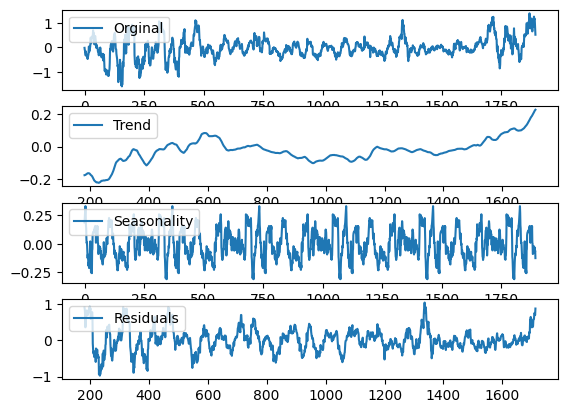

In [19]:
## plot the components

plt.subplot(411)
plt.plot(df['iot_sensor_reading'], label="Orginal")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(irregular, label="Residuals")
plt.legend(loc="upper left")

plt.show()

<Axes: >

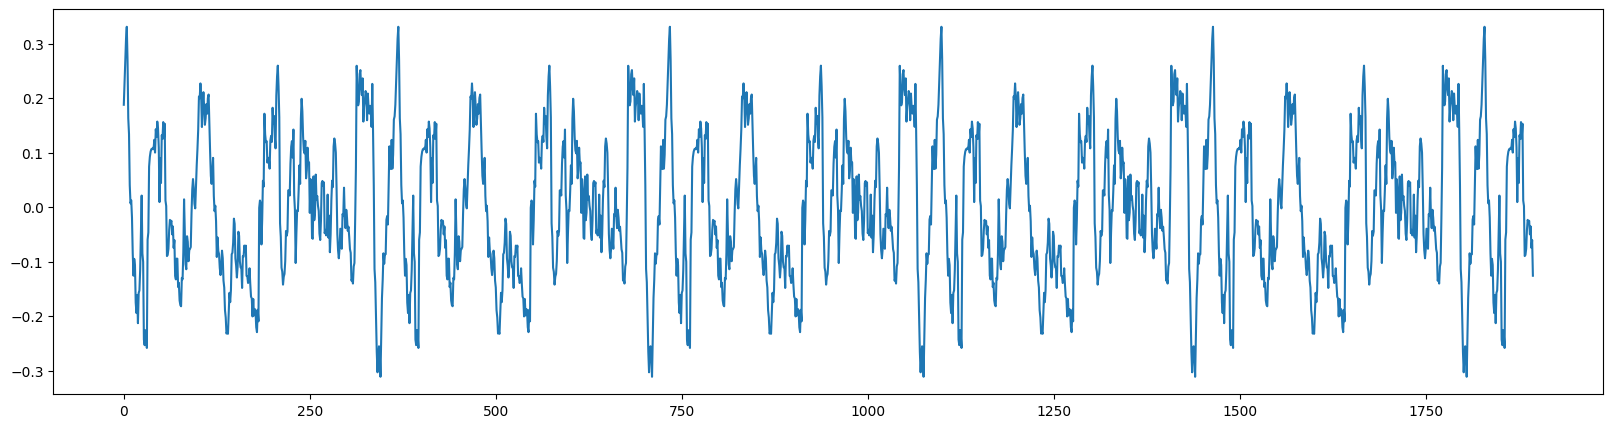

In [21]:
seasonal.plot(figsize=(20, 5))

<Axes: >

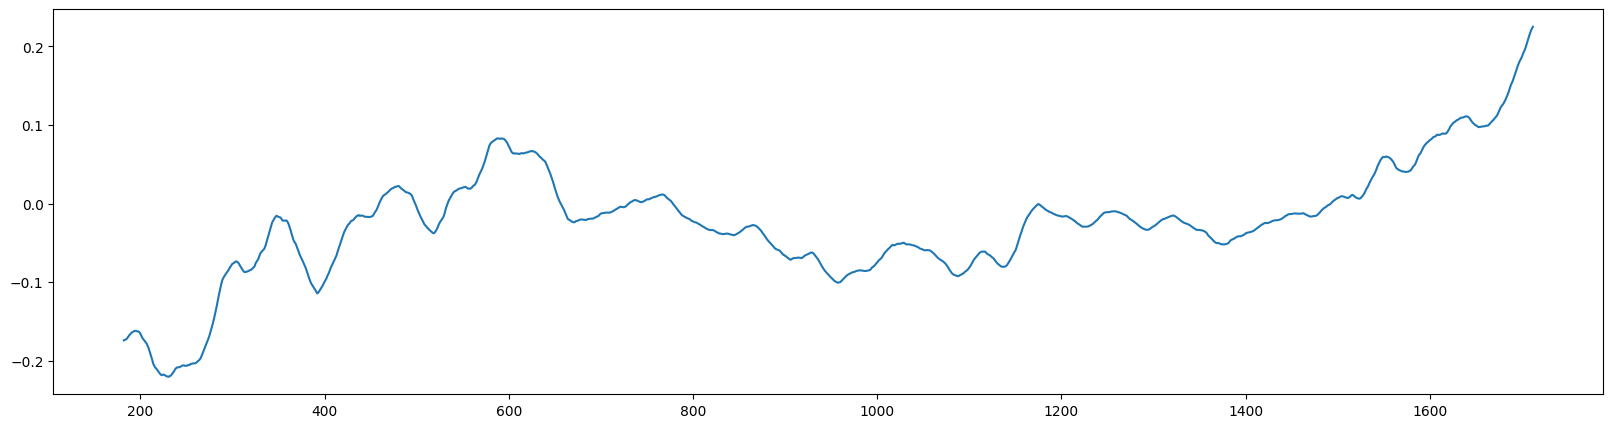

In [22]:
trend.plot(figsize=(20, 5))

<Axes: >

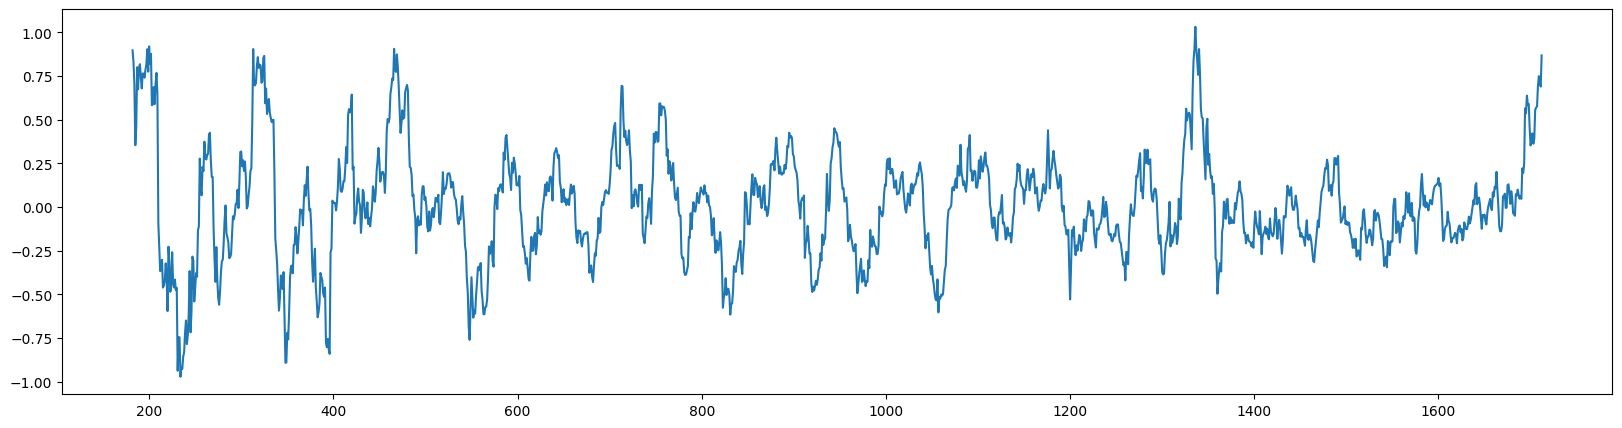

In [23]:
irregular.plot(figsize=(20, 5))

## **Stationarity and Its Importance for Forecasting**

In time series analysis, stationarity is a crucial concept that plays a fundamental role in understanding and forecasting data. A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, remain constant over time. Conversely, a non-stationary time series exhibits varying statistical properties, making it challenging to model and predict accurately.

Importance of Stationarity for Forecasting:

* Consistency of Statistical Properties: Stationary time series exhibit consistent statistical properties over time, such as a constant mean and variance. This property allows us to make reliable assumptions about the behavior of the data and build models that remain valid over the entire time frame. In contrast, non-stationary time series often have changing statistical properties, which can lead to misleading conclusions and unreliable forecasts.

* Simplifies Modeling: Stationarity simplifies the modeling process by reducing the complexity and uncertainty associated with non-stationary data. In a stationary time series, the relationship between past and future observations remains relatively stable, allowing us to apply traditional statistical and mathematical techniques for forecasting. Modeling non-stationary data requires additional steps, such as differencing or transformation, to make the series stationary before applying forecasting methods.

* Assumptions of Forecasting Models: Many forecasting models, such as autoregressive integrated moving average (ARIMA), assume stationarity. These models are built upon the idea that the future behavior of a time series can be predicted based on its past behavior. Stationarity ensures that the underlying patterns and dynamics captured by these models remain stable over time, making the forecasts more reliable.

* Accurate Parameter Estimation: Stationarity enables accurate estimation of model parameters. In a stationary series, the statistical properties are time-invariant, allowing us to estimate model parameters based on the entire data without the risk of biased or inconsistent estimates. Non-stationary series, on the other hand, often require estimation techniques that consider the changing nature of the data, such as time-varying models or structural break analysis.

* Better Forecasting Performance: Forecasting models built on stationary time series tend to have better performance compared to those built on non-stationary data. Stationarity provides a stable foundation for modeling and capturing the underlying patterns, trends, and relationships within the data. This stability enhances the accuracy and reliability of forecasts, leading to better decision-making and planning.

Testing for Stationarity:

To assess stationarity, statistical tests like the Augmented Dickey-Fuller (ADF) test or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test can be performed. These tests examine the presence of unit roots or trends in the data and provide insights into the stationarity of the series. A stationary series will have a p-value below a certain threshold in these tests, indicating the rejection of the null hypothesis of non-stationarity.

If a time series is found to be non-stationary, it can be made stationary through techniques like differencing, logarithmic transformation, or seasonal adjustment. These transformations aim to eliminate the trend, seasonality, or other non-stationary components, making the series suitable for forecasting using stationary models.

## **Augmented Dickey Fuller Test**

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary or not. It is an extension of the Dickey-Fuller test and is widely used in time series analysis and forecasting.

The ADF test is based on the concept of unit roots, which indicate non-stationarity in a time series. Non-stationarity refers to the situation where the statistical properties of a time series, such as the mean and variance, are not constant over time. This makes it difficult to analyze and model the data accurately.

n time series analysis, a unit root is a characteristic of a time series that makes it non-stationary. A unit root implies that the time series has a root at exactly 1. Technically, a unit root exists in a time series when the coefficient of the lagged dependent variable is equal to 1 in the following equation:

Y(t) = α * Y(t-1) + Xe

In this equation, Y(t) represents the value of the time series at time 't', Y(t-1) represents the lagged value of the time series at time 't-1', α represents the coefficient of the lagged variable, and Xe represents an exogenous variable (a separate explanatory variable that is also a time series).

The presence of a unit root indicates non-stationarity in the time series. Non-stationarity means that the statistical properties of the time series, such as the mean and variance, are not constant over time. Instead, they exhibit trends or other patterns that make it difficult to analyze and model the data accurately.

When a time series has a unit root, it implies that the series has not reached a stable, equilibrium state and may exhibit persistent patterns or trends. As a result, the series may display random walks or exhibit behavior that is difficult to predict or forecast accurately.

The presence of unit roots in a time series affects the interpretation and modeling of the data. In order to apply many statistical techniques, including autoregressive integrated moving average (ARIMA) models, it is essential to transform the non-stationary series into a stationary one. This transformation often involves differencing the series to eliminate the unit root and make the series stationary.

Differencing is a common technique used to remove unit roots and make a time series stationary. By differencing, we compute the differences between consecutive observations in the series, effectively eliminating the trends and non-stationarity caused by the unit root. The differenced series can then be analyzed and modeled using various time series techniques.

The null hypothesis of the ADF test is that the time series has a unit root, which implies non-stationarity. The alternate hypothesis is that the time series is stationary. The test statistic is computed, and based on its value and the associated p-value, a decision is made whether to reject the null hypothesis or not.

The ADF test involves estimating the following regression equation:

ΔY(t) = α + βt + γY(t-1) + δ₁ΔY(t-1) + δ₂ΔY(t-2) + ... + δₙΔY(t-n) + ε(t)

In this equation, ΔY(t) represents the differenced series at time 't', Y(t-1) represents the lagged value of the series, α represents the intercept term, β represents the coefficient of time trend, γ represents the coefficient of the lagged variable, δ₁, δ₂, ..., δₙ represent the coefficients of the differenced series, and ε(t) represents the error term.

Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

## **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is a statistical test used to determine the stationarity of a time series. Unlike the Augmented Dickey-Fuller (ADF) test, which tests for the presence of unit roots, the KPSS test examines the null hypothesis that the time series is stationary against the alternative hypothesis of a unit root or non-stationarity.

The KPSS test is based on the following regression equation:

Y(t) = μ + ε(t) + Σₖ(γₖ * tₖ) + Σₘ(δₘ * Zₘ) + ν(t)

In this equation, Y(t) represents the observed time series at time 't', μ represents the intercept term, ε(t) represents the error term, tₖ represents the time trend, γₖ represents the coefficient of the time trend, Zₘ represents the exogenous variables, δₘ represents the coefficient of the exogenous variables, and ν(t) represents the stochastic component of the model.

The KPSS test involves estimating the above regression equation and computing the test statistic, which is based on the sum of squared residuals from the regression. The test statistic is compared to critical values to determine whether to reject the null hypothesis of stationarity or not.

The null hypothesis of the KPSS test is that the time series is stationary, while the alternative hypothesis is that the time series has a unit root or is non-stationary. The test statistic follows a specific distribution, and its critical values are used to determine the rejection region.

In order to reject the null hypothesis, the test statistic should be greater than the provided critical values. If it is in fact higher than the target critical value, then that should automatically reflect in a low p-value.

That is, if the p-value is less than 0.05, the kpss statistic will be greater than the 5% critical value.

Finally, the number of lags reported is the number of lags of the series that was actually used by the model equation of the kpss test.

The major difference between the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test and the Augmented Dickey-Fuller (ADF) test lies in their respective capabilities to assess stationarity in the presence of a deterministic trend.

The ADF test is primarily designed to detect the presence of a unit root in a time series, which indicates non-stationarity. It assumes that the underlying data generating process includes a stochastic trend component. In other words, the ADF test is effective in identifying non-stationarity caused by a random walk or a trend that follows a linear or polynomial pattern.

On the other hand, the KPSS test is specifically designed to examine the stationarity of a time series in the presence of a deterministic trend. The word ‘deterministic’ implies the slope of the trend in the series does not change permanently. That is, even if the series goes through a shock, it tends to regain its original path.

The KPSS test extends the analysis beyond the presence of a unit root and allows for the examination of stationarity when a deterministic trend is present. It tests the null hypothesis that the time series is stationary against the alternative hypothesis of a unit root or non-stationarity with a deterministic trend.

By considering the presence of a deterministic trend, the KPSS test provides a more comprehensive assessment of the stationarity of a time series.


## **Stationary check using ADF and KPSS**

we plot the original time series using plt.plot(). This allows us to visually inspect the data to see if it appears to be stationary or non-stationary.

To test for stationarity, we use the adfuller() function from the statsmodels library. We pass in the value column of the DataFrame and the function returns an Augmented Dickey-Fuller test result which includes an ADF statistic, a p-value, and critical values for different levels of significance.

Based on the p-value, we can determine if the original time series is stationary or non-stationary. If the p-value is less than the significance level (e.g. 0.05), we reject the null hypothesis and conclude that the time series is stationary. If the p-value is greater than the significance level, we fail to reject the null hypothesis and conclude that the time series is non-stationary.

If the original time series is non-stationary, we can difference the data using the diff() function and then test for stationarity of the differenced time series using adfuller() again. If the differenced time series is stationary, we can use it for further analysis.

Finally, we plot the differenced time series using plt.plot() to visualize the difference.

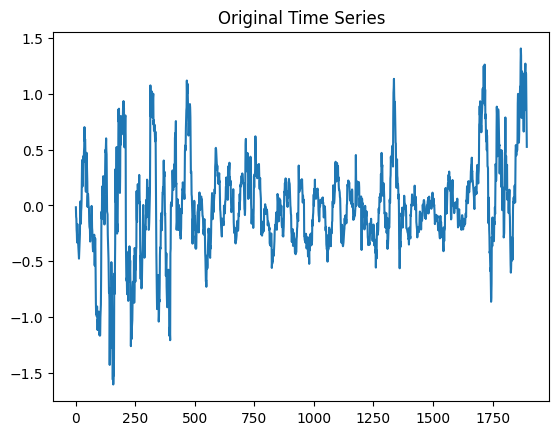

ADF Statistics: -6.151071555003591
P value: 7.560062499191265e-08
Critical Values:
1% :  -3.4338536404563853
5% :  -2.863087660163165
10% :  -2.5675939181074106


In [41]:
#Test for stationarity

#using adf

#Plot the time series
plt.plot(df['iot_sensor_reading'])
plt.title("Original Time Series")
plt.show()

result = adfuller(df['iot_sensor_reading'])

print("ADF Statistics:", result[0])
print("P value:", result[1])
print("Critical Values:" )

for key, value in result[4].items():
    print(key, ": ", value)

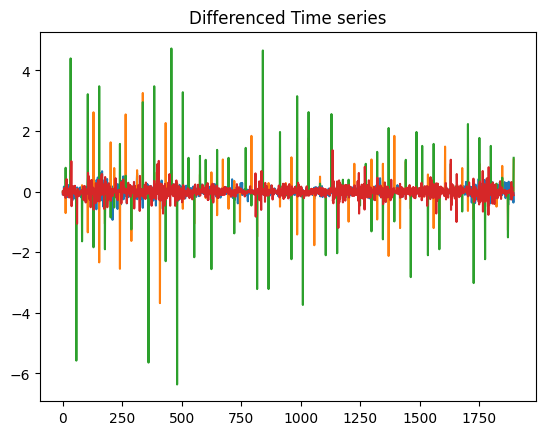

In [38]:
# difference between the time series and plot
diff_data = df.select_dtypes(np.number).diff().dropna()
plt.plot(diff_data)
plt.title("Differenced Time series")
plt.show()

In [39]:
#Test for stationarity for differenced timed series
result = adfuller(diff_data['iot_sensor_reading'])

print("ADF Statistics:", result[0])
print("P value:", result[1])

print("Critical Values:" )

for key, value in result[4].items():
    print(key, ": ", value)

ADF Statistics: -12.855816720053433
P value: 5.234938750940062e-24
Critical Values:
1% :  -3.4338536404563853
5% :  -2.863087660163165
10% :  -2.5675939181074106


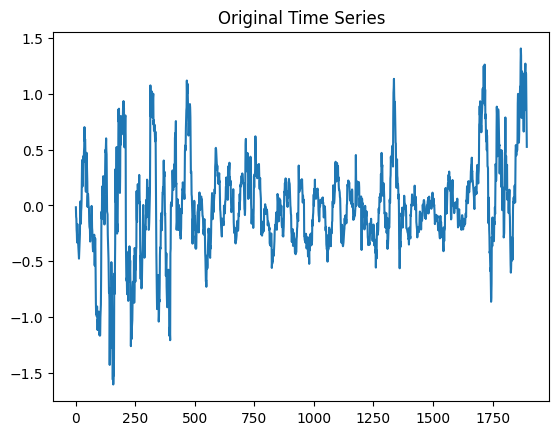

KPSS Statistics: 0.7710149110583773
p_value 0.01
10% :  0.347
5% :  0.463
2.5% :  0.574
1% :  0.739


In [42]:
## Using KPSS

#Plot the time series
plt.plot(df['iot_sensor_reading'])
plt.title("Original Time Series")
plt.show()

#perform KPSS Test
result = kpss(df['iot_sensor_reading'])

#extract and print results
kpss_statistic = result[0]
p_value = result[1]
critical_values = result[3]

print("KPSS Statistics:", kpss_statistic)
print("p_value", p_value)
for key, value in critical_values.items():
    print(key, ": ", value)

##  **ACF and PACF plots**

ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are graphical tools used in time series analysis to understand the correlation and relationship between observations in a time series.

#### **Autocorrelation Function (ACF) Plot:**
The ACF plot measures the correlation between an observation in a time series and its lagged values. It provides information about the linear relationship between the current observation and its past observations at different lags. The ACF plot shows the correlation coefficients on the y-axis and the lags on the x-axis.
Interpreting the ACF plot:

If the ACF plot shows a significant positive correlation at lag 1 (the first lag), it suggests that the current observation is positively correlated with its immediate past observation.
If the ACF plot shows a significant negative correlation at lag 1, it indicates a negative correlation between the current observation and its immediate past observation.
If the ACF plot shows significant correlations at multiple lags, it suggests a repeating pattern or a trend in the time series.


#### **Partial Autocorrelation Function (PACF) Plot:**
The PACF plot measures the correlation between an observation in a time series and its lagged values while removing the influence of intervening observations. It provides insights into the direct relationship between the current observation and its past observations, excluding the influence of other lags.
Interpreting the PACF plot:

The PACF plot helps identify the order of an autoregressive (AR) model. An AR model uses past observations as predictors for the current observation.
If the PACF plot shows a significant spike at lag 1 and no significant spikes at other lags, it suggests an AR(1) model, where the current observation depends only on the immediate past observation.
If the PACF plot shows significant spikes at multiple lags, it suggests an AR model with multiple lags.
Both the ACF and PACF plots help in determining the order of autoregressive and moving average components in an ARIMA model. By analyzing the decay of the correlation coefficients in the plots, one can identify potential values for the order of AR and MA terms, which are crucial for model selection and forecasting in time series analysis.

<Figure size 1000x400 with 0 Axes>

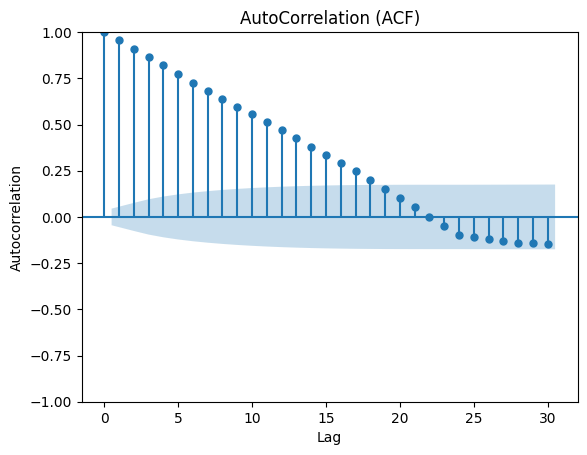

In [43]:
#Plot ACF

plt.figure(figsize=(10, 4))
plot_acf(df["iot_sensor_reading"], lags=30)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("AutoCorrelation (ACF)")
plt.show()

<Figure size 1000x400 with 0 Axes>

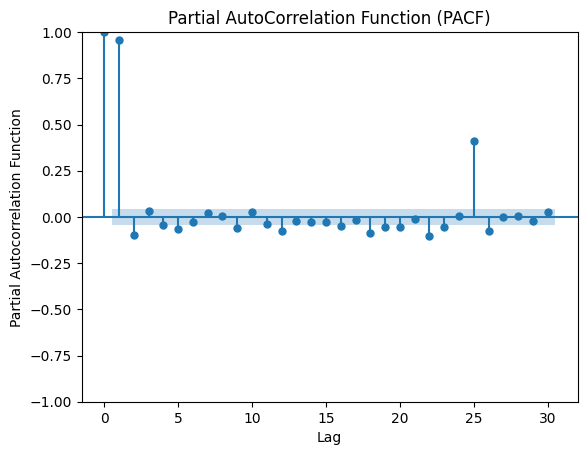

In [45]:
#Plot ACF

plt.figure(figsize=(10, 4))
plot_pacf(df["iot_sensor_reading"], lags=30)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation Function")
plt.title("Partial AutoCorrelation Function (PACF)")
plt.show()

## **White Noise**


White noise refers to a random sequence of uncorrelated and independent variables with constant mean and variance. In the context of time series analysis, white noise is a fundamental concept that serves as a building block for more complex models.

Characteristics of white noise:

Constant Mean: The mean of white noise remains constant over time. It is usually assumed to be zero for simplicity, but it can have any other fixed value.

Constant Variance: The variance of white noise is constant across all time points. It implies that the variability or dispersion of the random variables does not change over time.

No Autocorrelation: In white noise, there is no systematic relationship or correlation between the current observation and any of its past or future observations. Each observation is independent and unrelated to the others.

Normally Distributed: White noise is often assumed to follow a normal distribution, although this is not a strict requirement. The key characteristic is that the random variables are uncorrelated and have a constant mean and variance.

Importance of white noise:

White noise serves as a reference or benchmark against which other time series patterns and structures can be compared. It is used in various ways in time series analysis, including:

Model Diagnostics: White noise is often used as a null model to test the validity of more complex time series models. By comparing the residuals of a model to white noise, we can assess the adequacy of the model and check if it captures all the important patterns in the data.

Simulating Data: White noise can be used as a basis for generating simulated data that mimics certain characteristics of the original time series. By adding appropriate patterns or structures to white noise, we can create more realistic and complex time series simulations.

Estimating Parameters: White noise assumptions are often made in the estimation of parameters in time series models. For example, in the estimation of autoregressive (AR) or moving average (MA) coefficients, white noise assumptions allow for efficient estimation techniques such as the method of least squares or maximum likelihood estimation.

In [47]:
#set random for reproducibility

#Generate white noise
num_samples = 1000
white_noise = np.random.normal(loc=df.iot_sensor_reading.mean(), scale=df.iot_sensor_reading.std(), size=len(df))
df["white_noise"] = white_noise
df.describe()

,time,iot_sensor_reading,error_present,sensor_2,sensor_value,white_noise
count,1895,1895.000000,1895.000000,1895.000000,1895.000000,1895.000000
mean,2017-10-08 09:40:54.459102720,-0.005885,0.003773,-0.011604,-0.026563,-0.013567
min,2017-08-29 11:00:00,-1.603790,-3.115077,-3.281895,-1.468581,-1.272791
25%,2017-09-18 16:30:00,-0.222198,-0.424783,-0.853293,-0.230738,-0.308770
50%,2017-10-08 10:00:00,-0.022220,0.000000,0.065638,-0.065150,-0.012417
75%,2017-10-28 03:30:00,0.190455,0.424783,0.787655,0.207664,0.264474
max,2017-11-17 00:00:00,1.406987,3.256671,4.397739,1.460437,1.401996
std,NaN,0.415492,0.820630,1.324344,0.405068,0.421486


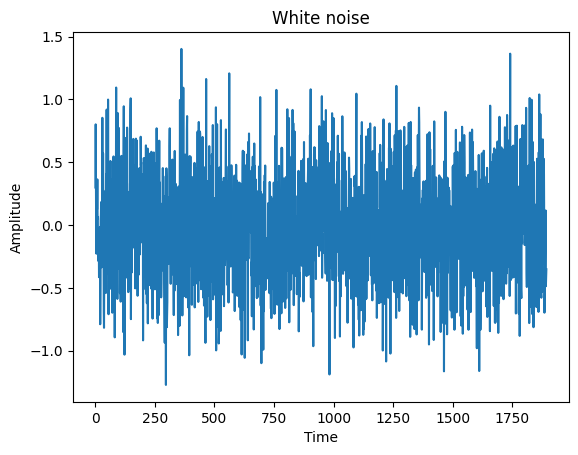

In [48]:
#plot white noise

plt.plot(white_noise)
plt.title("White noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

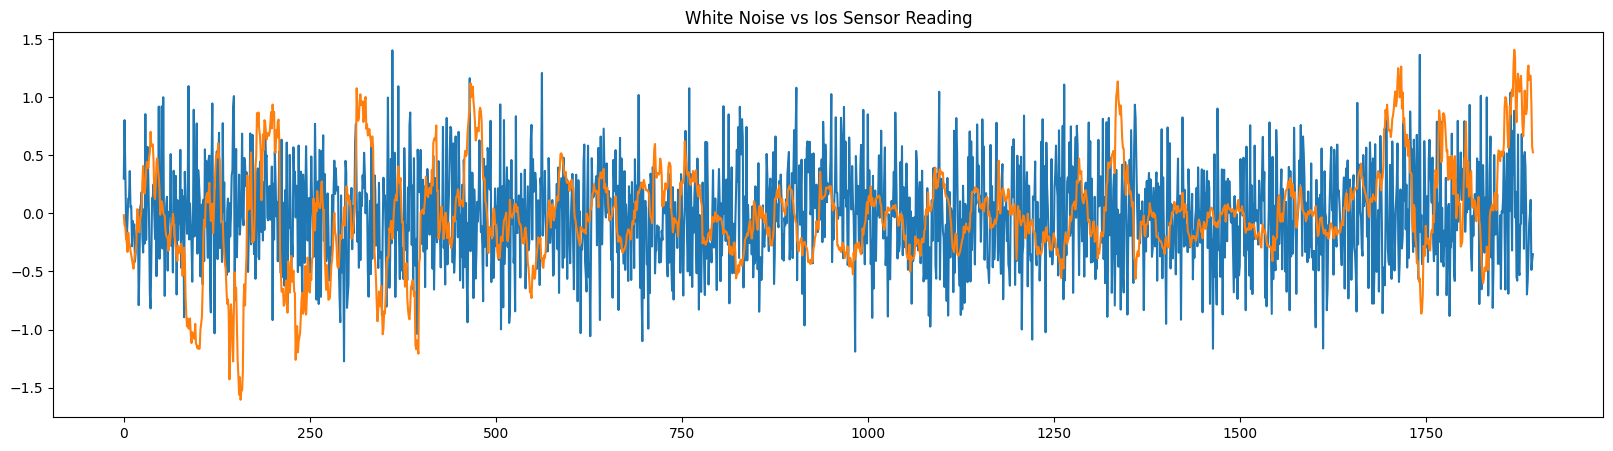

In [50]:
df.white_noise.plot(figsize=(20, 5))
df.iot_sensor_reading.plot(figsize=(20, 5))
plt.title("White Noise vs Ios Sensor Reading")
plt.show()

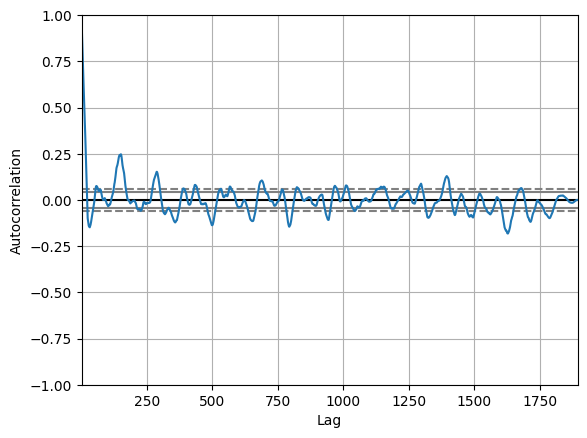

In [58]:
autocorrelation_plot(df.iot_sensor_reading)
plt.show()

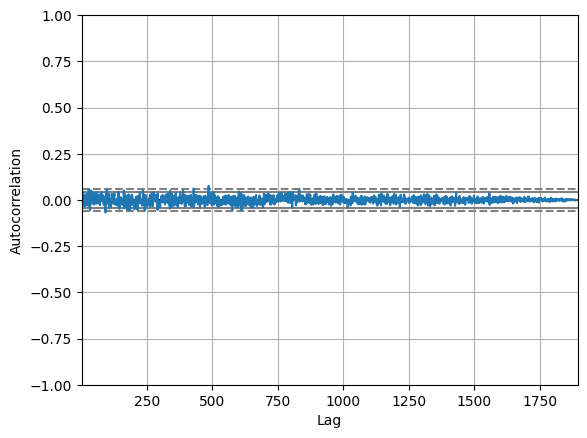

In [59]:
autocorrelation_plot(df.white_noise)
plt.show()

## **Random Walk**

A random walk is a mathematical model that describes a path or trajectory of a variable where each step or movement is determined randomly. It is a time series model that has important applications in various fields, including finance, economics, and physics. Understanding random walks is essential for analyzing and forecasting time series data.

Characteristics of a random walk:

Random Steps: In a random walk, each step or movement is determined randomly. At each time period, the variable can move up or down with equal probability. The direction and magnitude of the movement are typically based on a random process, such as a coin toss or a random number generator.

Cumulative Sum: The value of the variable at any given time is the cumulative sum of all the previous random steps. It means that the current value depends on the previous values and the sequence of random steps taken.

Drift: A random walk can have a drift component, which represents a systematic trend or bias in the movement of the variable. If there is a drift, the average movement of the variable over time will be non-zero. Without a drift, the average movement will be zero.

Properties of a random walk:

Trendless: A random walk without a drift is trendless. It means that the variable moves randomly around a fixed mean without any systematic upward or downward trend. The absence of a drift implies that the expected value of the variable remains constant over time.

Non-stationary: A random walk is generally non-stationary. Stationarity refers to a property of time series where the statistical properties, such as mean and variance, do not change over time. In a random walk, the mean and variance of the variable increase as the number of steps or time periods increases. Therefore, the statistical properties change over time, indicating non-stationarity.

Applications of random walks:

Financial Markets: Random walks are widely used to model stock prices and other financial variables. The efficient market hypothesis suggests that stock prices follow a random walk with a drift component, implying that it is impossible to consistently outperform the market based on historical price patterns.

Econometrics: Random walks serve as a benchmark model in econometric analysis. They are used to test for the presence of unit roots, which indicate non-stationarity, and to analyze the long-term relationships between variables.

Monte Carlo Simulations: Random walks are employed in Monte Carlo simulations to generate random sequences of variables with specific statistical properties. These simulations are used to model and analyze complex systems in various fields.

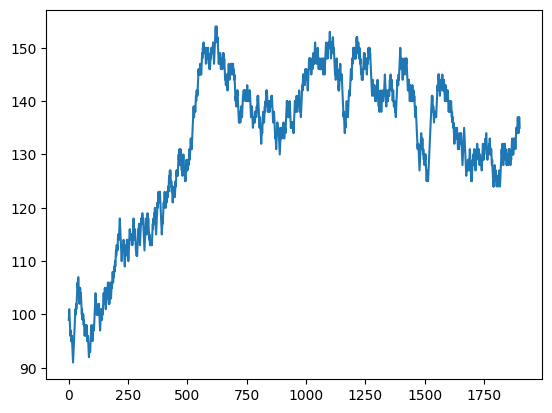

In [60]:
# set random seed for reproducibility

walk = [99]

for i in range(1900):
    #create random noise
    noise = -1 if np.random.random() < 0.5 else 1
    walk.append(walk[-1] + noise)
plt.plot(walk)

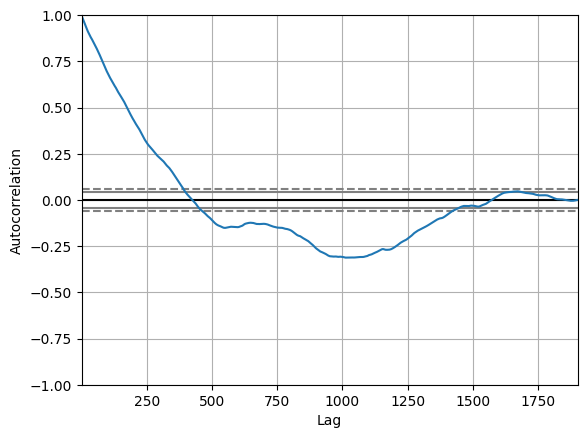

In [62]:
autocorrelation_plot(walk)
plt.show()

## **Moving Average Model**

The moving average (MA) model is a time series model that is widely used for forecasting and analyzing time-dependent data. It is a part of the broader class of autoregressive moving average (ARMA) models. The MA model describes the relationship between the observed values of a time series and the previous forecast errors.

Mathematically, an MA(q) model of order q is defined as:

X(t) = μ + ε(t) + θ₁ε(t-1) + θ₂ε(t-2) + ... + θqε(t-q)

where:

X(t) represents the value of the time series at time t.
μ is the mean of the time series.
ε(t) is the white noise error term at time t.
θ₁, θ₂, ..., θq are the parameters of the MA model that measure the influence of the previous forecast errors.
q is the order of the MA model, representing the number of lagged forecast errors considered.
Key points about the MA model:

Mean: The mean of the MA model is denoted by μ. It represents the long-term average of the time series.

Error Terms: The ε(t), ε(t-1), ..., ε(t-q) are the white noise error terms at different lags. These error terms are assumed to be independent and identically distributed with a mean of zero and constant variance.

Parameters: The θ₁, θ₂, ..., θq are the parameters of the MA model. They determine the influence of the previous forecast errors on the current value of the time series. The parameters are typically estimated using methods such as maximum likelihood estimation.

Order: The order of the MA model, denoted by q, specifies the number of lagged forecast errors included in the model. It determines the number of parameters that need to be estimated.

Stationarity: The MA model is stationary if the absolute values of the parameters θ₁, θ₂, ..., θq are all less than 1. Stationarity ensures that the mean and variance of the time series do not change over time.

Forecasting: The MA model is used for forecasting future values of the time series. To generate forecasts, the model utilizes the past observed values and the forecast errors from previous time periods.

Identification: The identification of an MA model involves determining the appropriate order q by analyzing the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the time series.

## Approach One

<Axes: >

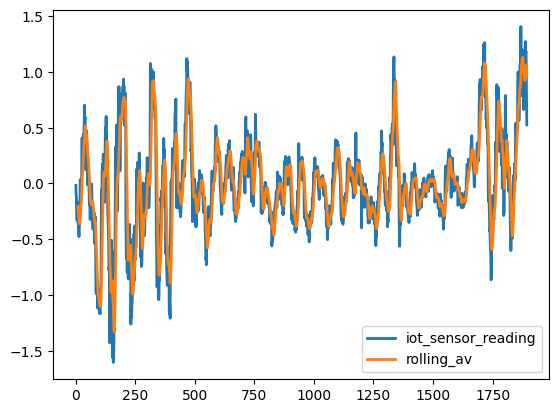

In [66]:
df["rolling_av"] = df.iot_sensor_reading.rolling(10).mean()
df[["iot_sensor_reading", "rolling_av"]].plot(lw=2)

## Approach Two

RMSE: 0.24646272606022593


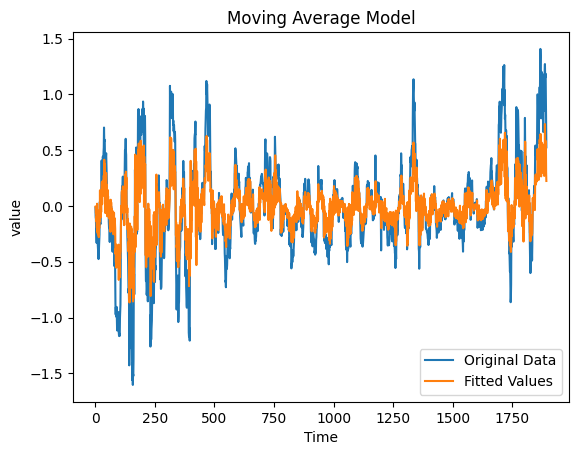

                               SARIMAX Results                                
Dep. Variable:     iot_sensor_reading   No. Observations:                 1895
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -35.395
Date:                Tue, 16 Apr 2024   AIC                             76.791
Time:                        18:04:38   BIC                             93.432
Sample:                             0   HQIC                            82.918
                               - 1895                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.010     -0.544      0.587      -0.026       0.015
ma.L1          0.8490      0.010     81.434      0.000       0.829       0.869
sigma2         0.0607      0.001     40.786      0.0

In [77]:
order = (0, 0, 1)
model = ARIMA(df.iot_sensor_reading, order = order)

model_fit = model.fit()

fitted_values = model_fit.fittedvalues

rmse = np.sqrt(mean_squared_error(df["iot_sensor_reading"], fitted_values))
print(f"RMSE: {rmse}")


plt.plot(df.iot_sensor_reading, label="Original Data")
plt.plot(fitted_values, label="Fitted Values")
plt.legend()
plt.title("Moving Average Model")
plt.xlabel("Time")
plt.ylabel("value")
plt.show()

print(model_fit.summary())

## **AutoRegression Model**


Autoregressive (AR) models are a class of time series models that capture the relationship between a variable and its own past values. In an autoregressive model, the value of a variable at a given time point is linearly dependent on its past values.

Mathematically, an autoregressive model of order p, denoted as AR(p), can be expressed as:

Y(t) = c + φ1 * Y(t-1) + φ2 * Y(t-2) + ... + φp * Y(t-p) + ε(t)

where:

Y(t) represents the value of the variable at time t.
c is a constant term.
φ1, φ2, ..., φp are the autoregressive coefficients, which determine the weight or impact of each lagged value on the current value.
Y(t-1), Y(t-2), ..., Y(t-p) represent the lagged values of the variable.
ε(t) is the error term or random disturbance at time t, which captures the unexplained variation in the model.
The autoregressive coefficients (φ1, φ2, ..., φp) determine the memory or persistence of the process. A higher autoregressive order (p) implies a longer memory, as the current value depends on more past values. The constant term (c) represents the intercept or the mean of the process.

To estimate the parameters of an autoregressive model, various techniques can be employed, such as the method of least squares or maximum likelihood estimation. The model parameters are usually estimated by minimizing the sum of squared errors between the predicted values and the actual values.

The order (p) of the autoregressive model is an important consideration. It determines the number of lagged values included in the model. The appropriate order can be determined through various methods, such as visual inspection of autocorrelation and partial autocorrelation plots, information criteria (e.g., AIC, BIC), or statistical tests (e.g., Ljung-Box test).

Once the parameters are estimated, an autoregressive model can be used for forecasting. Given the past values of the variable, the model can generate predictions for future time points. The forecasted values are obtained by recursively applying the autoregressive equation.







## First Order Model

We create an AR model using the AutoReg class from statsmodels.tsa.ar_model. The lags parameter is set to 1, indicating that we are considering only one lag for the autoregressive component.

Next, we fit the model to the data using the fit() method of the AutoReg model.

We obtain the fitted values of the model using model_fit.fittedvalues, which represent the predicted values based on the AR model.

To visualize the original data and the fitted values, we plot them using plt.plot().

Finally, we print the summary of the model using model_fit.summary(), which provides information about the model coefficients, standard errors, and other diagnostic statistics.

Keep in mind that when working with AR models, it is essential to ensure that the data satisfies the assumptions of the AR model, such as stationarity and independence of residuals. Additionally, you may need to consider appropriate lag order selection based on techniques like autocorrelation and partial autocorrelation analysis


RMSE: 0.01696940558828999


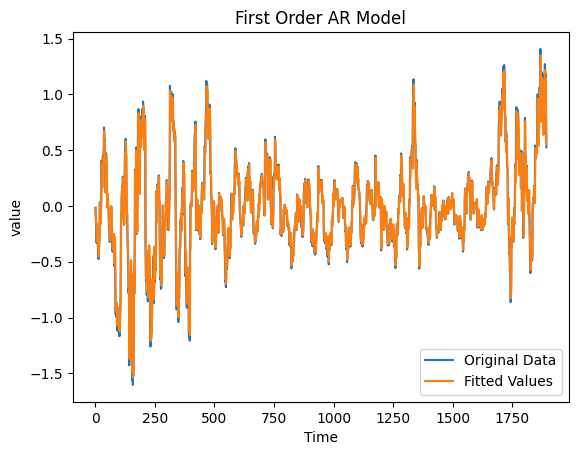

                            AutoReg Model Results                             
Dep. Variable:     iot_sensor_reading   No. Observations:                 1895
Model:                     AutoReg(1)   Log Likelihood                1358.079
Method:               Conditional MLE   S.D. of innovations              0.118
Date:                Tue, 16 Apr 2024   AIC                          -2710.157
Time:                        18:25:43   BIC                          -2693.518
Sample:                             1   HQIC                         -2704.031
                                 1895                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.387e-05      0.003      0.012      0.990      -0.005       0.005
iot_sensor_reading.L1     0.9591      0.007    146.756      0.000       0.946       0.972
        

In [81]:
order = 1
model = AutoReg(df.iot_sensor_reading, lags = order)

model_fit = model.fit()

fitted_values = model_fit.fittedvalues

rmse = np.sqrt(mean_squared_error(df["iot_sensor_reading"][:-1], fitted_values))
print(f"RMSE: {rmse}")


plt.plot(df.iot_sensor_reading, label="Original Data")
plt.plot(fitted_values, label="Fitted Values")
plt.legend()
plt.title("First Order AR Model")
plt.xlabel("Time")
plt.ylabel("value")
plt.show()

print(model_fit.summary())